This file computes the profile of temperature in an Arctic or Alpine typical snowpack overlying a dry soil. These simulations were used for a paper : Major Issues in Simulating some Arctic Snowpack Properties Using Current Detailed Snow Physics Models. Consequences for the Thermal Regime and Water Budget of Permafrost by Florent Domine, Ghislain Picard, Samuel Morin, Mathieu Barrere, Jean-Benoît Madore, Alexandre Langlois, to be published in *Journal of Advances in Modeling Earth Systems*.

This notebook uses data published by Nordicana D29 / http://dx.doi.org/10.5885/45460CE-9B80A99D55F94D95

In [1]:
import sys

%matplotlib notebook
import matplotlib.pyplot as plt

sys.path.append("..")
import numpy as np
from mfm import model, model_dirichlet, Parameters, MeteoData
from collections import namedtuple

import pandas as pd
import xarray as xr

In [2]:
# configurations (see further in the code and in the paper for details)
# YEAR of simulation
#year = 2014
year = 2013

# TYPE OF SNOWPACK
zone = 'arctic'
#zone = 'alpine'

# SOIL
soil = 'frozen'
#soil = 'original'
#soil = 'frozen-deep'

# NB LAYERS
nlyr_snow = 60  # layers are 1cm thick

In [3]:
meteo = xr.open_dataset("bylot-island-forcing/FORCING_bylot-hyb_snowf.nc")
if year == 2013:
    meteo = meteo.sel(time=slice('2013-10-01', '2014-05-29'))
else:
    meteo = meteo.sel(time=slice('2014-10-01', '2015-05-29'))

# read meteo
time = meteo['time']
def meteo_iterator(meteo_xr):
    for dt, meteo in meteo_xr.groupby('time'):
        md = MeteoData(datetime=dt,
                       tair=meteo['Tair'].item(),
                       qair=meteo['Qair'].item(),
                       windspeed=meteo['Wind'].item(),
                       swdn=meteo['DIR_SWdown'].item()+meteo['SCA_SWdown'].item(),
                       lwdn=meteo['LWdown'].item(),
                       pressure=meteo['PSurf'].item())
        yield md



In [4]:
if year == 2013:
    tsurf_filename = 'bylot-island-forcing/BylstaSurfaceT2013-2014.csv'
else:
    tsurf_filename = 'bylot-island-forcing/BylstaSurfaceT2014-2016.csv'
    
df = pd.read_csv(tsurf_filename, index_col='TMSTAMP', parse_dates=True)

tsurf = df.resample('100s').interpolate()['Surface TempC_Avg']
tsurf += 273.15

In [5]:
if zone == 'arctic':
    rho_snow = [400, 300, 200]
    ks_snow = [0.25, 0.1, 0.05]
elif zone == 'alpine':
    rho_snow = [200, 300, 400]
    ks_snow = [0.05, 0.1, 0.25]
else:
    raise Exception()

if "deep" in soil:
    nlyr_soil = 3000 # 30 m
else:
    nlyr_soil = 1000 # 10 m

if soil.startswith('frozen'):
    rho_soil = 1600.
    cp_soil  = 800.
    ks_soil   = 2.
elif soil.startswith('original'):
    rho_soil = 1600.
    cp_soil  = 800.
    ks_soil   = 0.8
else:
    raise Exception("which soil?")
tbase = 273. - 10

if nlyr_snow == 60:
    z_output = [-5, 0, 1, 2, 20, 40, 44, 60]
elif nlyr_snow == 30:
    z_output = [-5, 0, 1, 2, 10, 20, 22, 30]
else:
    raise Exception("change z_output")

meantair = np.mean(np.mean(meteo['Tair'])).item()

nlyr = nlyr_snow + nlyr_soil

nlyr_snow_3 = nlyr_snow//3

params = Parameters(dt=100,
                   albedo=0.85,
                   z0=0.01, #e-2,
                   zt=2.0,
                   dx=1e-2 * np.ones(nlyr),
                   cp=np.array([152.75 + 7.1 * meantair] * nlyr_snow + [cp_soil] * nlyr_soil),  # for the ice and soil
                   ks=np.array([ks_snow[0]]*nlyr_snow_3 + [ks_snow[1]]*nlyr_snow_3 + [ks_snow[2]]*nlyr_snow_3 + [ks_soil]*nlyr_soil),
                   rho=np.array([rho_snow[0]]*nlyr_snow_3 + [rho_snow[1]]*nlyr_snow_3 + [rho_snow[2]]*nlyr_snow_3 + [rho_soil]*nlyr_soil),
                   tbase=tbase,
                   V = 3 #Wm -2 K -1
                  )

z = -np.cumsum(np.insert(params.dx, 0, 0))[:-1] + nlyr_snow*1e-2
iz_output = [nlyr_snow - z for z in z_output]

In [6]:
# run the simulation now.
# One simulation take approximately 1min. Be patient.
temp_n_arr = []
temp_d_arr = []
temp_n = None
temp_d = None

i = 0
time = []
for md in meteo_iterator(meteo):
    if temp_n is None: # initialize
        if nlyr_soil <=1000:
            temp_n = np.concatenate((np.linspace(263, 273, nlyr_snow), np.linspace(273, tbase, nlyr_soil)))
        else:
            temp_n = np.concatenate((np.linspace(263, 273, nlyr_snow), np.linspace(273, tbase, 1000), np.full(nlyr_soil-1000, tbase)))
        temp_d = temp_n.copy()

    for j in range(0, 3*3600, params.dt):
        dt = md.datetime+np.timedelta64(j, 's')
        try:
            temp_n, flux = model(md, temp_n, params, return_flux=True)
        except ZeroDivisionError as e:
            print(md)
            raise(e)
        temp_d = model_dirichlet(tsurf.loc[dt], temp_d, params)
        if (j % 3600) == 0:
            time.append(dt)
            temp_n_arr.append(temp_n)
            temp_d_arr.append(temp_d)            
    i+=1
    
    #if i>100: break
temp_n_arr = np.array(temp_n_arr)
temp_d_arr = np.array(temp_d_arr)

<IPython.core.display.Javascript object>


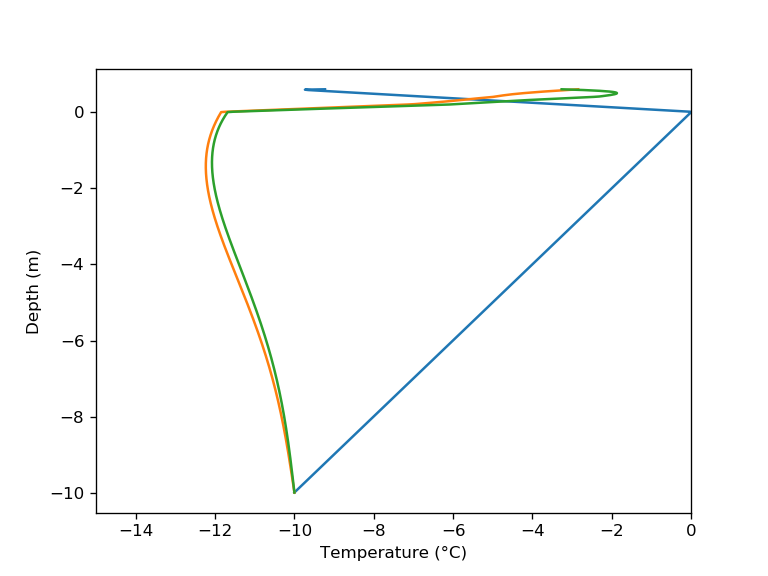

Text(0, 0.5, 'Depth (m)')

In [7]:
# plot the profiles at the end of the simulation (around May)
plt.figure()
plt.plot(temp_n_arr[0,:]-273, z)
plt.plot(temp_n_arr[-1,:]-273, z)
plt.plot(temp_d_arr[-1,:]-273, z)
plt.xlim((-15, 0))
plt.xlabel("Temperature (°C)")
plt.ylabel("Depth (m)")

In [8]:
# write out the results

for temp_arr, label in [(temp_n_arr, 'neuman'), (temp_d_arr, 'dirichlet')]:
    output_temp = np.take(temp_arr-273, iz_output, axis=1)
    columns = [('%f' % (z[iz]*100)) for iz in iz_output]
    df = pd.DataFrame(output_temp, columns=columns, index=time)
    if year == 2013:
        df = df['2013-10-01':].resample('1H').mean()
    else:
        df = df['2014-10-01':].resample('1H').mean()
    df.to_csv('output-%s-%s-%icm-%s-%ssoil.csv' % (year, zone, nlyr_snow, label, soil))


In [9]:
!ls -l output-201*.csv

-rw-r--r-- 1 picardgh domainusers 1018710 nov.  12 09:57 output-2013-arctic-60cm-dirichlet-frozensoil.csv
-rw-r--r-- 1 picardgh domainusers 1018372 nov.  12 09:57 output-2013-arctic-60cm-neuman-frozensoil.csv


<IPython.core.display.Javascript object>


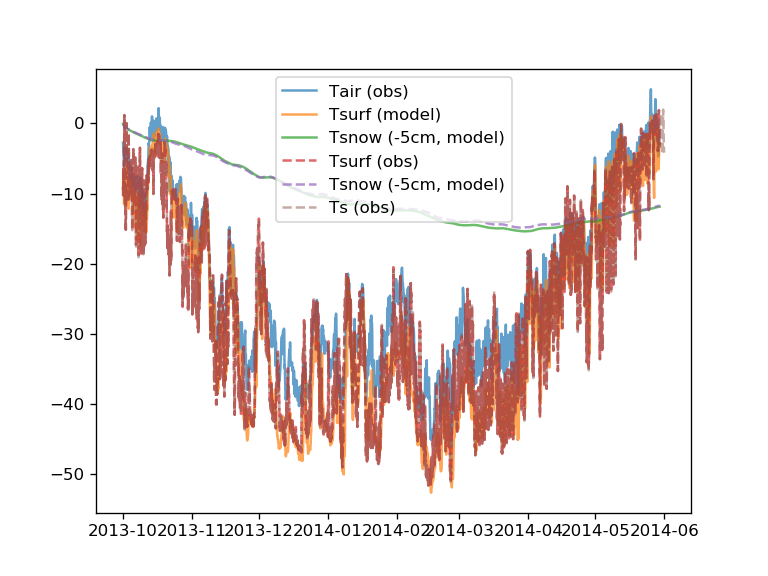

In [10]:
f, ax = plt.subplots(1, 1, sharex=True)
ax=[ax]
ax[0].plot(meteo.time, meteo['Tair']-273, label='Tair (obs)', alpha=0.7)
ax[0].plot(time, temp_n_arr[:, 0]-273, label='Tsurf (model)', alpha=0.7)
ax[0].plot(time, temp_n_arr[:, iz_output[0]]-273, label='Tsnow (-5cm, model)', alpha=0.7)

ax[0].plot(time, temp_d_arr[:, 0]-273, '--', label='Tsurf (obs)', alpha=0.7)
ax[0].plot(time, temp_d_arr[:, iz_output[0]]-273, '--', label='Tsnow (-5cm, model)', alpha=0.7)

ax[0].plot(tsurf.index, tsurf-273, '--', label='Ts (obs)', alpha=0.5)


ax[0].legend()
